In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/FYP/Speaker/Contrastive')
os.environ['TF_CPP_MIN_LOG_LEVEL']= '3'

import tensorflow as tf
tf.autograph.set_verbosity(0)

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from siamese import Siamese
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
MODEL_PATH = 'Model/LSTM/'
CORE_PATH = '../Classification/Model/LSTM/'
DATA_PATH = '../Data/Data/'

In [5]:
print('Loading data')
with open(DATA_PATH + 'train.pickle', 'rb') as f:
    X_train, s_train = pickle.load(f)
with open(DATA_PATH + 'val.pickle', 'rb') as f:
    X_val, s_val = pickle.load(f)

Loading data


In [6]:
def get_pairs(X, s, sim):
    speakers = list(s.keys())
    num = len(speakers)
    
    if sim:
        s1 = np.random.randint(0, num)
        l1, h1 = s[speakers[s1]]
        
        i1_1 = np.random.randint(l1, h1+1) - l1
        i1_2 = np.random.randint(l1, h1+1) - l1
        while i1_2 == i1_1:
            i1_2 = np.random.randint(l1, h1+1) - l1
            
        p1 = abs(X[s1][i1_1])
        p2 = abs(X[s1][i1_2])
        y = 0.
        
    else:
        s1 = np.random.randint(0, num)
        s2 = np.random.randint(0, num)
        while s1 == s2:
            s2 = np.random.randint(0, num)
            
        l1, h1 = s[speakers[s1]]
        l2, h2 = s[speakers[s2]]
        
        i1 = np.random.randint(l1, h1+1) - l1
        i2 = np.random.randint(l2, h2+1) - l2
        
        p1 = abs(X[s1][i1])
        p2 = abs(X[s2][i2])
        y = 1.
    
    return p1.reshape(W, H, 1), p2.reshape(W, H, 1), y

def get_batch(X, s, batch_size):
    pair1 = []
    pair2 = []
    labels = []
    
    for _ in range(batch_size // 2):
        p1, p2, y = get_pairs(X, s, True)
        pair1.append(p1)
        pair2.append(p2)
        labels.append(y)
        
    for _ in range(batch_size // 2):
        p1, p2, y = get_pairs(X, s, False)
        pair1.append(p1)
        pair2.append(p2)
        labels.append(y)
        
    pair1, pair2, labels = np.array(pair1), np.array(pair2), np.array(labels)
    _ = np.random.permutation(len(pair1))
    return [pair1[_], pair2[_]], labels[_]

In [7]:
def train_generator(batch_size):
    while True:
        X, y = get_batch(X_train, s_train, batch_size)
        yield X, y
        
def val_generator(batch_size):
    while True:
        X, y = get_batch(X_val, s_val, batch_size)
        yield X, y

In [8]:
BATCH_SIZE = 128
MARGIN = 0.5
LR = 0.0006
W = 300
H = 128
EPOCHS = 50
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 50

In [9]:
def train(model):
    filepath = MODEL_PATH + 'lstm_{epoch:02d}.h5'
    checkpoint = ModelCheckpoint(filepath, save_weights_only=True, period=10)
    history = model.model.fit(train_generator(BATCH_SIZE), epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH, callbacks=[checkpoint],
                              validation_data=(val_generator(BATCH_SIZE)),
                              validation_steps=VALIDATION_STEPS, shuffle=True)
                              
    return history

In [10]:
print('Creating Model')
model = Siamese((W, H, 1), name='lstm', lr=LR, margin=MARGIN, core_path=CORE_PATH+'lstm_20.h5')
model.model.summary()

Creating Model
Model: "lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          2569152     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0

In [11]:
history = train(model)

Epoch 1/50
100/100 [==============================] - 25s 133ms/step - loss: 0.0817 - val_loss: 0.0570
Epoch 2/50
100/100 [==============================] - 12s 116ms/step - loss: 0.0508 - val_loss: 0.0474
Epoch 3/50
100/100 [==============================] - 12s 115ms/step - loss: 0.0433 - val_loss: 0.0470
Epoch 4/50
100/100 [==============================] - 12s 115ms/step - loss: 0.0430 - val_loss: 0.0447
Epoch 5/50
100/100 [==============================] - 12s 117ms/step - loss: 0.0411 - val_loss: 0.0391
Epoch 6/50
100/100 [==============================] - 11s 115ms/step - loss: 0.0378 - val_loss: 0.0395
Epoch 7/50
100/100 [==============================] - 12s 116ms/step - loss: 0.0387 - val_loss: 0.0359
Epoch 8/50
100/100 [==============================] - 12s 118ms/step - loss: 0.0368 - val_loss: 0.0409
Epoch 9/50
100/100 [==============================] - 12s 116ms/step - loss: 0.0379 - val_loss: 0.0375
Epoch 10/50
100/100 [==============================] - 12s 117ms/step - l

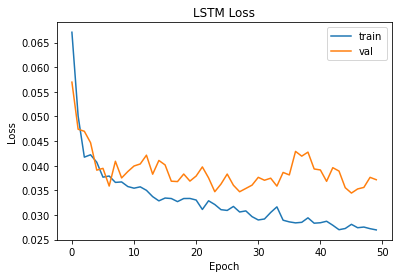

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [13]:
with open(MODEL_PATH + 'lstm_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)